In [1]:
!pip install --upgrade tensorflow==1.15

Requirement already up-to-date: tensorflow==1.15 in /usr/local/lib/python3.7/dist-packages (1.15.0)


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Variable Pembantu
layer = {
    'input' : 1,
    'output' : 1
}

EPOCH = 1000
batch_size = 2
time_step = 12

In [4]:
# Function Load Data
def load_dataset():
  dataset = pd.read_csv('Alcohol_Sales.csv', index_col='DATE')
  dataset.index = pd.to_datetime(dataset.index)
  return dataset

In [5]:
# Function Batch Learning
def get_batch(dataset, time_step, batch_size):
  input_batch = np.zeros(shape=(batch_size, time_step, layer['input']))
  output_batch = np.zeros(shape=(batch_size, time_step, layer['output']))
  
  for i in range(batch_size):
    point = np.random.randint(0, len(dataset) - time_step)
    input_batch += dataset[point : point + time_step]
    output_batch += dataset[point + 1 : point + time_step + 1]

  return input_batch, output_batch

In [6]:
dataset = load_dataset()

In [7]:
# Split dataset
split = int(len(dataset) * 0.8)
train_dataset = dataset[:split]
test_dataset = dataset[split:] # Tidak ad proses testing sebenarnya

In [8]:
# Normalize Dataset
scaler = MinMaxScaler().fit(train_dataset)
normalize_train_dataset = scaler.transform(train_dataset)

In [9]:
# Building Model
# Hidden Layer
cell = tf.nn.rnn_cell.BasicRNNCell(10, activation=tf.nn.relu)

# Output Layer
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, layer['output'], activation = tf.nn.relu)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [10]:
input_feature = tf.placeholder(tf.float32, [None, time_step, layer['input']])
input_target = tf.placeholder(tf.float32, [None, time_step, layer['output']])

In [11]:
output, _ = tf.nn.dynamic_rnn(cell, input_feature, dtype = tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
# MSE
loss = tf.reduce_mean(0.5 * (input_target - output) ** 2)
train = tf.train.AdamOptimizer(0.0001).minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
saver = tf.train.Saver()

In [14]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for i in range(1, EPOCH+1):
    input_batch, output_batch = get_batch(normalize_train_dataset, time_step, batch_size)

    feed = {
        input_feature: input_batch,
        input_target: output_batch
    }
    
    sess.run(train, feed_dict = feed)

    if i % 200 == 0:
      print('Iteration: {}, Loss: {}'.format(i, sess.run(loss, feed_dict = feed)))
      
    saver.save(sess, './rnn-model.ckpt')

Iteration: 200, Loss: 0.010756261646747589
Iteration: 400, Loss: 0.04258188232779503
Iteration: 600, Loss: 0.008077308535575867
Iteration: 800, Loss: 0.007959856651723385
Iteration: 1000, Loss: 0.007229493465274572


INFO:tensorflow:Restoring parameters from ./rnn-model.ckpt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


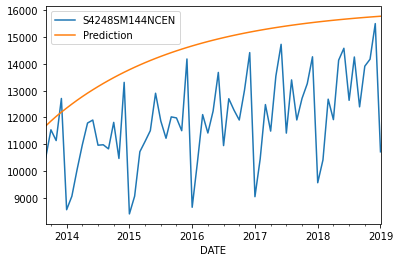

In [15]:
with tf.Session() as sess:
  seed_data = list(normalize_train_dataset)
  saver.restore(sess, './rnn-model.ckpt')

  for i in range(len(test_dataset)):
    input_batch = np.array(seed_data[-time_step:]).reshape([1, time_step, layer['input']])
    feed = {
        input_feature: input_batch,
    }

    predict = sess.run(output, feed_dict=feed)
    seed_data.append(predict[0, -1, 0])

  predict_result = scaler.inverse_transform(np.array(seed_data[-len(test_dataset):]).reshape([len(test_dataset), 1]))
  test_dataset['Prediction'] = predict_result
  test_dataset.plot()
  plt.show()
